<a href="https://colab.research.google.com/github/DomizianoScarcelli/big-data-project/blob/item-based-cf/NN_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies

In [1]:
!pip install petastorm -qq
!pip install pyspark -qq
!pip install -U -q PyDrive -qq
!apt install openjdk-8-jdk-headless -qq

openjdk-8-jdk-headless is already the newest version (8u372-ga~us1-0ubuntu1~20.04).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
#@title Imports
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly

import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType, LongType
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT

from tqdm.notebook import tqdm
import time
import gc
import torch
from typing import Tuple, List


from google.colab import drive
from petastorm import make_batch_reader
from petastorm.pytorch import DataLoader

In [3]:
#@title Set up variables
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Big Data/datasets"
DATASET_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_friendly_spotify_playlist_dataset")
AUDIO_FEATURES_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_track_features")
LITTLE_SLICE_FILE = os.path.join(GDRIVE_DATA_DIR, "little_slice")
SMALL_SLICE_FLIE = os.path.join(GDRIVE_DATA_DIR, "small_slice")
LITTLE_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "little_slice_audio_features")
MICRO_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "micro_slice_audio_features")
SPLITTED_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "splitted_pyspark_track_features")
SAVED_DFS_PATH = os.path.join(GDRIVE_DATA_DIR, "saved_dfs")
RANDOM_SEED = 42 # for reproducibility
SAVED_MODELS = os.path.join(GDRIVE_DATA_DIR, "saved_models")
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PYSPARK_PYTHON"]="python"

In [4]:
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


In [5]:
#@title Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '12G').\
                set('spark.driver.memory', '12G').\
                set('spark.driver.maxResultSize', '100G').\
                set("spark.executor.extraJavaOptions", "-XX:+UseG1GC").\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Data acquisition

In [6]:
playlist_schema_mapped = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", VectorUDT(), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
NUM_PLAYLISTS = 100_000
SONGS_EMBEDDINGS_PATH = os.path.join(SAVED_DFS_PATH, f"songs_embeddings-train-{NUM_PLAYLISTS}.json")
SONGS_INFO_DF_PATH = os.path.join(SAVED_DFS_PATH, f"songs_info_df-train-{NUM_PLAYLISTS}.json")
SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"songs_vector_length-train-{NUM_PLAYLISTS}.txt")

ARTIST_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"artist_vector_length-train-{NUM_PLAYLISTS}.txt")
ARTISTS_EMBEDDINGS_PATH = os.path.join(SAVED_DFS_PATH, f"artists_embeddings-train-{NUM_PLAYLISTS}.json")

In [9]:
songs_embeddings = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH)
artists_embeddings = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH)

with open(ARTIST_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  ARTIST_VECTOR_LENGTH = int(content) + 1
with open(SONGS_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  SONGS_VECTOR_LENGTH = int(content) + 1

In [10]:
songs_embeddings.show(), artists_embeddings.show(), ARTIST_VECTOR_LENGTH, SONGS_VECTOR_LENGTH

+-------------+-------------+----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|         name|collaborative| pid|modified_at|num_tracks|num_albums|num_followers|              tracks|num_edits|duration_ms|num_artists|
+-------------+-------------+----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|       disney|        false|1000| 1457827200|       189|        16|            1|(578642,[1,568,17...|        4|   31428282|         65|
|Indie Electro|        false|1001| 1417824000|       165|        18|            2|(578642,[1177,299...|        2|   38241566|          8|
|  jack & jack|        false|1002| 1465430400|        17|        14|            1|(578642,[13565,15...|        3|    3549358|          3|
|        vibes|        false|1003| 1498435200|       225|       195|            2|(578642,[569,570,...|       91|   51242585|        157|
|        Indie|        false|1004|

(None, None, 98065, 578642)

# Convert PySpark DataFrame into PyTorch DataLoader

In [11]:
def convert_sparse_to_indices(df: DataFrame) -> DataFrame:
  """
  Given a dataframe fo columns "pos":int and "tracks":SparseVector, it returns a new dataframe where
  the SparseVector are replaced with a list of the indices where the values are.
  (The value information is lost, but we don't care since they are binary values so they will be all ones)
  """

  @F.udf(returnType=ArrayType(IntegerType()))
  def transform_array(item: SparseVector):
    """
    Given a SparseVector (binary) it returns the tuple that represent it, of the type (size, indices)
    """
    indices_list = item.indices.tolist()
    padding_width = max_songs - len(indices_list)
    return indices_list + [-1] * padding_width
  
  max_songs = songs_embeddings.select(F.max("num_tracks")).first()[0]
  print(f"Max number of songs: {max_songs}")
  df = df.withColumn("embedding_indices", transform_array(F.col("tracks"))).drop("tracks")
  return df


In [12]:
def padded_tensors_to_sparse_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    rows.append(sparse_tensor)
  return torch.stack(rows)

def padded_tensors_to_dense_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    dense = sparse_tensor.to_dense()
    rows.append(dense)
  unpadded = torch.stack(rows)
  return unpadded

In the paper they have two matrices,l et $n$ be the number of unique songs, $m$ the number of playlists and $k$ the number of unique artists:

- $P \in \mathbb{R}^{m \times n}$ where $p_i = 1$ if song $i$ is in the playlist, $p_i=0$ otherwise
- $A \in \mathbb{R}^{m \times k}$ where $a_i=1$ if the artist is present in the playlist, $a_i = 0$ otherwise

In [13]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from petastorm.unischema import dict_to_spark_row, Unischema, UnischemaField
from petastorm.codecs import ScalarCodec, CompressedImageCodec, NdarrayCodec
from torchvision import transforms
from petastorm import TransformSpec

CACHE = os.path.join(GDRIVE_DIR, "/big_data/cache_5")
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df = convert_sparse_to_indices(songs_embeddings.select("tracks"))
songs_converter = make_spark_converter(pytorch_songs_df)

pytorch_artists_df = convert_sparse_to_indices(artists_embeddings.select("tracks"))
artist_converter = make_spark_converter(pytorch_artists_df)

Max number of songs: 250


Max number of songs: 250


# PyTorch Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle


class DAE_tied(nn.Module):
    def __init__(self, conf):
        super(DAE_tied, self).__init__()
        self.save_dir = conf["save"]

        self.n_batch = conf["batch"]
        self.n_input = conf["n_input"]
        self.n_hidden = conf["hidden"]
        self.learning_rate = conf["lr"]
        self.reg_lambda = conf["reg_lambda"]

        self.x_positions = torch.LongTensor()
        self.x_ones = torch.FloatTensor()

        self.y_positions = torch.LongTensor()
        self.y_ones = torch.FloatTensor()

        self.keep_prob = torch.tensor(conf["keep_prob"], dtype=torch.float32)
        self.input_keep_prob = torch.tensor(conf["input_keep_prob"], dtype=torch.float32)

        self.weights = {}
        self.biases = {}
        self.d_params = []

    def init_weight(self):
        self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden))
        nn.init.xavier_uniform_(self.weights['encoder_h'])
        self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden))
        nn.init.zeros_(self.biases['encoder_b'])
        self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input))
        nn.init.zeros_(self.biases['decoder_b'])
        self.d_params = [self.weights['encoder_h'], self.biases['encoder_b'], self.biases['decoder_b']]

    # Building the encoder
    def encoder(self, x):
        # Encoder Hidden layer with sigmoid activation #1
        layer = torch.add(torch.matmul(x, self.weights['encoder_h']), self.biases['encoder_b'])
        layer = torch.sigmoid(layer)
        layer = torch.nn.functional.dropout(layer, p=1 - self.keep_prob)

        return layer

    # Building the decoder
    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['encoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
      encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
      decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
      encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2

      l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2
      return l2

    def forward(self, x, y):

        # TODO: Take sparse matrix representation instead of dense
        # self.x = x_positxions
        # self.x_ones = x_ones
        # self.y_positions = y_positions
        # self.y_ones = y_ones

        self.x = x.t()
        self.y = y.t()

        # x_sparse = torch.sparse.FloatTensor(self.x_positions.t(), self.x_ones, torch.Size([self.n_batch, self.n_input]))
        # self.x = x_sparse.to_dense()
        # y_sparse = torch.sparse.FloatTensor(self.y_positions.t(), self.y_ones, torch.Size([self.n_batch, self.n_input]))
        # self.y = y_sparse.to_dense()

        x_dropout = torch.nn.functional.dropout(self.x, p= 1 - self.input_keep_prob) # Maybe error
        reduce_sum = torch.sum(x_dropout, dim=1, keepdim=True)
        self.x_dropout = torch.div(x_dropout, reduce_sum + 1e-10)

        encoder_op = self.encoder(self.x_dropout)
        self.y_pred = self.decoder(encoder_op)

        l2 = self.l2_loss()

        L = -torch.sum(self.y * torch.log(self.y_pred + 1e-10) +
                       0.55 * (1 - self.y) * torch.log(1 - self.y_pred + 1e-10), dim=1)
        self.cost = torch.mean(L) + self.reg_lambda * l2

    def save_model(self):
        params = [param.detach().numpy() for param in self.d_params]
        with open(self.save_dir, 'wb') as f:
            pickle.dump(params, f)

            
class DAE(DAE_tied):
    def __init__(self, conf):
        super(DAE, self).__init__(conf)
        self.initval_dir = conf["initval"]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def init_weight(self):
        if self.initval_dir == 'NULL':
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['encoder_h'])
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['decoder_h'])
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
            nn.init.zeros_(self.biases['encoder_b'])
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
            nn.init.zeros_(self.biases['decoder_b'])
        else:
            with open(self.initval_dir, 'rb') as f:
                emb = pickle.load(f)
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(emb[0]).to(self.device))
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(emb[1]).to(self.device))
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(emb[2]).to(self.device))
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(emb[3]).to(self.device))

        self.d_params = [self.weights['encoder_h'], self.weights['decoder_h'],
                         self.biases['encoder_b'], self.biases['decoder_b']]

    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['decoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
      encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
      decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
      encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2
      decoder_h_l2 = (torch.sum(self.weights['decoder_h']) ** 2)/2

      l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2 + decoder_h_l2
      return l2

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
#Hyperparameters used in the paper
conf = {
    'batch': 250,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH,
    'hidden': 256,
    'lr': 0.0001,
    'reg_lambda': 0.0,
    'initval': "NULL",
    "keep_prob": 0.8, 
    "input_keep_prob": 0.8, # This isn't used for now because of the .uniform()
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
dae_model = DAE(conf)
dae_model.init_weight()
optimizer = optim.Adam(dae_model.d_params, lr=conf['lr'])
# optimizer = optim.SGD(dae_model.d_params, lr=conf['lr'], momentum=0.9)

In [29]:
dae_model.weights['encoder_h'].device

device(type='cuda', index=0)

## Train the model

In [ ]:
from tqdm.notebook import tqdm
import random

NUM_EPOCHS = 20
min_loss = 1_000
best_params = []
with songs_converter.make_torch_dataloader(num_epochs = NUM_EPOCHS) as songs_dataloader:
  with artist_converter.make_torch_dataloader(num_epochs = NUM_EPOCHS) as artists_dataloader:
    losses = []
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    # for epoch in tqdm(range(num_epochs), desc="Training..."):
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
      dae_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)


      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()

      losses.append(loss)

     
      if loss < min_loss:
        min_loss = loss
        del best_params
        best_params = [param.cpu().detach().numpy() for param in dae_model.d_params]
        print(f"Best loss achieved: {min_loss}, parameters saved!")

      if batch_idx % 10 == 0:
        print(f"Loss: {loss}")


Training model:   0%|          | 0/8000.0 [00:00<?, ?it/s]

Loss: 258017.84375
Loss: 234812.578125
Loss: 213689.015625
Loss: 194248.78125
Loss: 176658.5625
Loss: 160511.25
Loss: 148064.171875
Loss: 134272.78125
Loss: 122626.15625
Loss: 111868.8828125
Loss: 104109.09375
Loss: 96076.53125
Loss: 88825.140625
Loss: 82805.453125
Loss: 75210.59375
Loss: 70567.453125
Loss: 66198.5625
Loss: 61805.703125
Loss: 57858.609375
Loss: 55773.578125
Loss: 51150.0
Loss: 49050.70703125
Loss: 45357.2890625
Loss: 43484.328125
Loss: 40650.4921875
Loss: 38192.625
Loss: 36816.890625
Loss: 35321.98046875
Loss: 33738.65625
Loss: 32283.421875
Loss: 30757.779296875
Loss: 29289.634765625
Loss: 27859.41015625
Loss: 26754.58203125
Loss: 25970.876953125
Loss: 24892.16796875
Loss: 23800.8515625
Loss: 22671.26171875
Loss: 21976.8359375
Loss: 21771.11328125
Loss: 20141.58984375
Loss: 19844.52734375
Loss: 18826.71484375
Loss: 18474.626953125
Loss: 17439.97265625
Loss: 17311.111328125
Loss: 16979.916015625
Loss: 15878.4619140625
Loss: 15841.494140625
Loss: 15043.36328125
Loss: 144

In [56]:
SAVE_MODEL_PATH = os.path.join(SAVED_DFS_PATH, f"model_1.pickle")
params = [param.cpu().detach().numpy() for param in dae_model.d_params]
with open(SAVE_MODEL_PATH, 'wb') as f:
  pickle.dump(params, f)

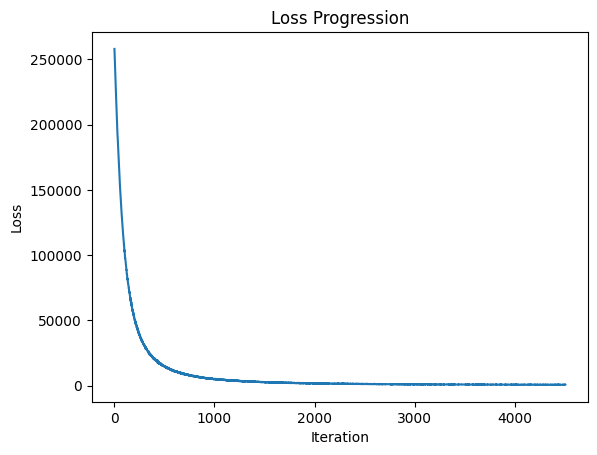

In [31]:
import matplotlib.pyplot as plt
x = np.arange(len(losses))
plt.plot(x, [loss.item() for loss in losses])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.show()

# Inference

In [14]:
SONGS_EMBEDDINGS_PATH_TEST = os.path.join(SAVED_DFS_PATH, f"songs_embeddings-test-{NUM_PLAYLISTS}.json")
SONGS_INFO_DF_PATH_TEST = os.path.join(SAVED_DFS_PATH, f"songs_info_df-test-{NUM_PLAYLISTS}.json")
SONGS_VECTOR_LENGTH_PATH_TEST = os.path.join(SAVED_DFS_PATH, f"songs_vector_length-test-{NUM_PLAYLISTS}.txt")

ARTIST_VECTOR_LENGTH_PATH_TEST = os.path.join(SAVED_DFS_PATH, f"artist_vector_length-test-{NUM_PLAYLISTS}.txt")
ARTISTS_EMBEDDINGS_PATH_TEST = os.path.join(SAVED_DFS_PATH, f"artists_embeddings-test-{NUM_PLAYLISTS}.json")

songs_embeddings_test = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH)
artists_embeddings_test = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH)

with open(ARTIST_VECTOR_LENGTH_PATH_TEST, "r") as f:
  content = f.read()
  ARTIST_VECTOR_LENGTH_TEST = int(content) + 1
with open(SONGS_VECTOR_LENGTH_PATH_TEST, "r") as f:
  content = f.read()
  SONGS_VECTOR_LENGTH_TEST = int(content) + 1


SONGS_DF_PATH_TEST = SONGS_INFO_DF = os.path.join(SAVED_DFS_PATH, f"songs_info_df-test-{NUM_PLAYLISTS}.json")
songs_df_test = spark.read.json(SONGS_DF_PATH_TEST)

SONGS_DF_PATH_TRAIN = SONGS_INFO_DF = os.path.join(SAVED_DFS_PATH, f"songs_info_df-test-{NUM_PLAYLISTS}.json")
songs_df_train = spark.read.json(SONGS_DF_PATH_TRAIN)


In [ ]:
# songs_embeddings_test.show(), artists_embeddings_test.show(), songs_df_test.show(), ARTIST_VECTOR_LENGTH_TEST, SONGS_VECTOR_LENGTH_TEST
# songs_df_test.count(), songs_df_train.count(), SONGS_VECTOR_LENGTH_TEST

In [15]:
def construct_prediction_df(prediction: torch.Tensor, mapping: DataFrame, top_n: int = 50) -> DataFrame:
  pred_np = prediction.detach().numpy()
  top_n_predictions = np.argpartition(pred_np, -top_n)[-top_n:]
  confidence = np.array(pred_np[top_n_predictions])
  schema = StructType([
      StructField("pos", IntegerType()),
      StructField("confidence", FloatType())
  ])
  prediction_df = spark.createDataFrame([(pos, conf) for pos, conf in zip(top_n_predictions.tolist(), confidence.tolist())],schema)
  prediction_info = prediction_df.join(mapping, "pos")
  return prediction_info.orderBy(F.col("confidence").desc())

# prediction_df = construct_prediction_df(prediction, songs_df_test)
# prediction_df.show()

# Evaluation

In [16]:
def precision_at_k(recommendations, ground_truth, num_of_recommendations) -> float:
    """
    Calculates precision at k for the recommendations.
    """
    recommended_relevant_tracks = recommendations.join(ground_truth, "track_uri").cache()
    reccomended_relevant_tracks_count = recommended_relevant_tracks.count() #this can be top_n_results.join in order to be more performant
    recommended_relevant_tracks.unpersist()
    precision = reccomended_relevant_tracks_count / float(num_of_recommendations)

    return precision


import math
def normalized_discounted_cumulative_gain(recommendations: DataFrame, ground_truth: DataFrame, num_of_recommendations: int) -> float:
  recommendations_list = recommendations.collect()
  cumulative_gain = 0

  intersection = recommendations.join(ground_truth, "track_uri").count()
  if intersection == 0: return 0

  ideal_cumulative_gain = 1 + np.array([(1 / math.log(i, 2)) for i in range(2, 2+intersection)]).sum() #TODO: replace this with sum([])
  for index, row in enumerate(recommendations_list):
    i = index + 1
    is_rel = ground_truth.filter(F.col("track_uri").isin(row.track_uri)).count() > 0
    rel = 1 if is_rel else 0
    if i == 1:
      cumulative_gain += rel
    else:
      cumulative_gain += (rel / math.log(i, 2))
  return cumulative_gain / ideal_cumulative_gain

Creating the dataloaders for the test set

In [17]:
CACHE = os.path.join(GDRIVE_DIR, "/big_data/cache_5")
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df_test = convert_sparse_to_indices(songs_embeddings_test.select("tracks"))
songs_converter_test = make_spark_converter(pytorch_songs_df_test)

pytorch_artists_df_test = convert_sparse_to_indices(artists_embeddings_test.select("tracks"))
artist_converter_test = make_spark_converter(pytorch_artists_df_test)

Max number of songs: 250


Max number of songs: 250


In [20]:
#Hyperparameters used in the paper
conf = {
    'batch': 150,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH,
    'hidden': 256,
    'lr': 0.001, #original 0.001
    'reg_lambda': 0.001,
    'initval': os.path.join(SAVED_DFS_PATH, f"model_1.pickle"),
    "keep_prob": 1,
    "input_keep_prob": 1,
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
dae_model_test = DAE(conf)
dae_model_test.init_weight()

In [23]:
ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
with songs_converter_test.make_torch_dataloader(num_epochs =1) as songs_dataloader:
  with artist_converter_test.make_torch_dataloader(num_epochs=1) as artists_dataloader:
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Evaluation...", total= (NUM_PLAYLISTS / 32)):
      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)
      
      x = torch.concat((song_dense, artist_dense), dim=1).t()
      y = torch.concat((song_dense, artist_dense), dim=1).t()
      dae_model_test(x,y)
      result = dae_model_test.y_pred
      break

Evaluation...:   0%|          | 0/3125.0 [00:00<?, ?it/s]

In [64]:
result = result.to("cpu")
prediction_df = construct_prediction_df(result[10][:SONGS_VECTOR_LENGTH_TEST], songs_df_test, 20)

In [65]:
prediction_df.show()

+------+-----------+--------------------+
|   pos| confidence|           track_uri|
+------+-----------+--------------------+
| 33880| 0.06791539|spotify:track:7KX...|
| 56220|  0.0657612|spotify:track:0Vg...|
|301808| 0.06285201|spotify:track:4Km...|
| 41162|0.059526257|spotify:track:3a1...|
| 44734| 0.05723577|spotify:track:1xz...|
| 17093| 0.05570554|spotify:track:0v9...|
|329617|  0.0549223|spotify:track:5Ct...|
| 42950|0.054365866|spotify:track:7GX...|
|343946|0.051512275|spotify:track:5hT...|
|337349|0.050608836|spotify:track:6HZ...|
|287650|0.049462624|spotify:track:7BK...|
|329636|0.047875628|spotify:track:3DX...|
|330215| 0.04761682|spotify:track:2EE...|
|303022|0.045975793|spotify:track:7yy...|
| 31474|0.045828294|spotify:track:6gB...|
|295928| 0.04570223|spotify:track:6eT...|
|  7106|0.045458216|spotify:track:4bH...|
|318834| 0.04462676|spotify:track:3B5...|
| 21844|0.044445533|spotify:track:62v...|
| 54409| 0.04356365|spotify:track:152...|
+------+-----------+--------------

In [24]:
from pyspark.ml.linalg import VectorUDT
song_schema = StructType([
    StructField("pos", IntegerType(), True),
    StructField("artist_name", StringType(), True),
    StructField("track_uri", StringType(), True),
    StructField("artist_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("album_uri", StringType(), True),
    StructField("duration_ms", LongType(), True),
    StructField("album_name", StringType(), True)
])

playlist_schema = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", ArrayType(song_schema), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])
TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"train_df-{NUM_PLAYLISTS}.json")
TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"test_df-{NUM_PLAYLISTS}.json")
train_df = spark.read.schema(playlist_schema).json(TRAIN_DF_PATH)
test_df = spark.read.schema(playlist_schema).json(TEST_DF_PATH)

In [25]:
def evaluate_batch(batch_result: torch.Tensor, batch_n: int) -> Tuple[float, float]:
  """
  Returns the precision and NDCG for a given batch.
  """
  
  return 0,0

def perform_evaluation(songs_dataloader, artists_dataloader, test_set):
  """
  Returns the precision and NDCG, averaged from all the samples in the test set
  """
  with songs_converter_test.make_torch_dataloader(num_epochs =1) as songs_dataloader:
    with artist_converter_test.make_torch_dataloader(num_epochs=1) as artists_dataloader:
      zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
      for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Evaluation...", total= (NUM_PLAYLISTS / 32) * NUM_EPOCHS):
        padded_song_tensor = song["embedding_indices"]
        padded_artist_tensor = artist["embedding_indices"]
        
        song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
        artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

        x = torch.concat((song_dense, artist_dense), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x,y)
        batch_result = dae_model.y_pred
        break


In [26]:
#Testing the first playlist
#TODO: maybe this is not the right way of making a prediction
results = []
for i in tqdm(range(32)):
  ground_truth = test_df.filter(F.col("pid") == 1000 + i).select(F.explode("tracks")).select("col.*")
  n_recommendations = ground_truth.count()
  result = result.cpu()

  prediction_df = construct_prediction_df(result[i][:SONGS_VECTOR_LENGTH_TEST], songs_df_test, n_recommendations)
  prec = precision_at_k(prediction_df, ground_truth, n_recommendations)
  gain = normalized_discounted_cumulative_gain(prediction_df, ground_truth, n_recommendations)
  print(i, prec, gain)
  results.append((prec, gain))
  # prediction_df.show(), prediction_df.join(ground_truth, "track_uri").show(), prec, gain


  0%|          | 0/32 [00:00<?, ?it/s]

0 0.0 0
1 0.0 0
2 0.0 0
3 0.05263157894736842 0.21440797356783975
4 0.0 0
5 0.0 0
6 0.0 0
7 0.06666666666666667 0.5
8 0.0 0
9 0.0 0
10 0.0 0
11 0.04 0.13511907721365987
12 0.0 0
13 0.0 0
14 0.0 0
15 0.0 0
16 0.08 0.3216045894712364
17 0.0 0
18 0.06060606060606061 0.1685425125627947
19 0.0 0
20 0.0 0
21 0.0 0
22 0.0 0
23 0.0 0
24 0.0 0
25 0.0 0
26 0.0 0
27 0.0 0
28 0.0 0
29 0.0 0
30 0.0 0
31 0.25 0.5


In [27]:
def average_results(results):
  prec_avg = sum(prec for prec, _ in results) / len(results)
  gain_avg = sum(gain for _, gain in results) / len(results)
  return prec_avg, gain_avg

average_results(results)

(0.01718450956937799, 0.057489817275485335)